# MPI calibration of a Grid5000 cluster

## Data extraction

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import numpy

archive_name = 'grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 8133

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

result = extract_zip(archive_name)

In [2]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808878 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dahu-15.grenoble.grid5000.fr:
    - (172.16.20.15) at 3c:fd:fe:55:ed:60 [ether] on enp24s0f0
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
dahu-15.grenoble.grid5000.

In [3]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

In [4]:
class Normal:
    '''
    Represent a variable following a normal distribution N(μ, σ²)
    '''
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            if self.sigma == 0:
                return str(self.mu)
            return 'N(%s, %s)' % (self.mu, self.sigma)

    def to_tex(self):
        if self.sigma == 0:
            return self.number_to_tex(self.mu, digits=2)
        return r'\mathcal{N}\left(%s, %s\right)' % (self.number_to_tex(self.mu, digits=2), self.number_to_tex(self.sigma, digits=2))

    def __add__(self, other):
        try:
            mu = self.mu + other.mu
            sigma = self.sigma + other.sigma
        except AttributeError:
            mu = self.mu + other
            sigma = self.sigma
        return Normal(mu, sigma)

    def __mul__(self, other):
        return Normal(self.mu, self.sigma*other)

    def __neg__(self):
        return Normal(-self.mu, self.sigma)

    def __sub__(self, other):
        return self + (-other)
    
    def sample(self):
        return numpy.random.normal(self.mu, self.sigma)

    @staticmethod
    def number_to_tex(x, digits=None):
        string = '%e' if digits is None else '%.{}e'.format(digits)
        string = string % x
        exp_i = string.index('e')
        coefficient = string[:exp_i]
        exponent = int(string[exp_i+1:])
        return r'%s\mathrm{e}{%d}' % (coefficient, exponent)

print(Normal(1, 2) - Normal(3, 4))
print([Normal(1, 2).sample() for _ in range(5)])

class LinearRegression:
    '''
    Represent a linear relation of the form y ~ αx + β
    Note that both α and β can be of any type, including random variables.
    '''
    def __init__(self, intercept, coefficient):
        if isinstance(intercept, (int, float)):
            intercept = Normal(intercept, 0)
        if isinstance(coefficient, (int, float)):
            coefficient = Normal(coefficient, 0)
        self.intercept = intercept
        self.coefficient = coefficient

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return 'Y ~ %sX + %s' % (self.coefficient, self.intercept)

    def to_tex(self):
        result =  r'Y \sim \alpha X + \beta\\'
        result += r'\alpha \sim %s\\' % self.coefficient.to_tex()
        result += r'\beta \sim %s\\' % self.intercept.to_tex()
        return result

    def sample(self, x):
        return self.coefficient.sample() * x + self.intercept.sample()

print(LinearRegression(Normal(1, 0.5), 5))
print([LinearRegression(Normal(1, 0.5), 5).sample(i) for i in range(5)])

<IPython.core.display.Math object>


[1.9046079014111235, 0.88363993408038, 0.7227911027221343, 0.1254816956943896, 1.6205529852634994]


<IPython.core.display.Math object>


[2.048255375836847, 6.044559250025048, 10.997327637655447, 15.711345197014733, 20.86681603511741]


In [5]:
class Mixture:
    '''
    Represent a variable following a mixture of (any) distribution.
    '''
    def __init__(self, *modes):
        '''
        The argument "modes" has to be a list of couples. The first element of each couple is the distribution, the second argument is a positive weight.
        '''
        self.modes = modes
        self.total_weight = 0
        for couple in self.modes:
            assert len(couple) == 2
            assert couple[1] > 0
            self.total_weight += couple[1]
        self.probabilities = [t[1] / self.total_weight for t in self.modes]

    def sample(self):
        mode_index = numpy.random.choice(a=len(self.modes), p=self.probabilities)
        return self.modes[mode_index][0].sample()

    def to_tex(self):
        result = []
        for distribution, weight in self.modes:
            result.append(r'%s & \text{ with probability } %s' % (distribution.to_tex(), Normal.number_to_tex(weight/self.total_weight, digits=2)))
        result = r'\\'.join(result)
        return '\\begin{cases}\n%s\\end{cases}' % result

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return 'Mixture(...)'

print([Mixture((Normal(-3, 1), 2), (Normal(5, 1), 1)).sample() for _ in range(5)])
Mixture((Normal(-3, 1), 2), (Normal(5, 1), 1))

[-2.5414913491745006, -3.4335502494948806, 3.5411273690780365, -2.6507586012814333, 5.8325035863725425]


<IPython.core.display.Math object>

## Analysis

In [6]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.formula.api as st

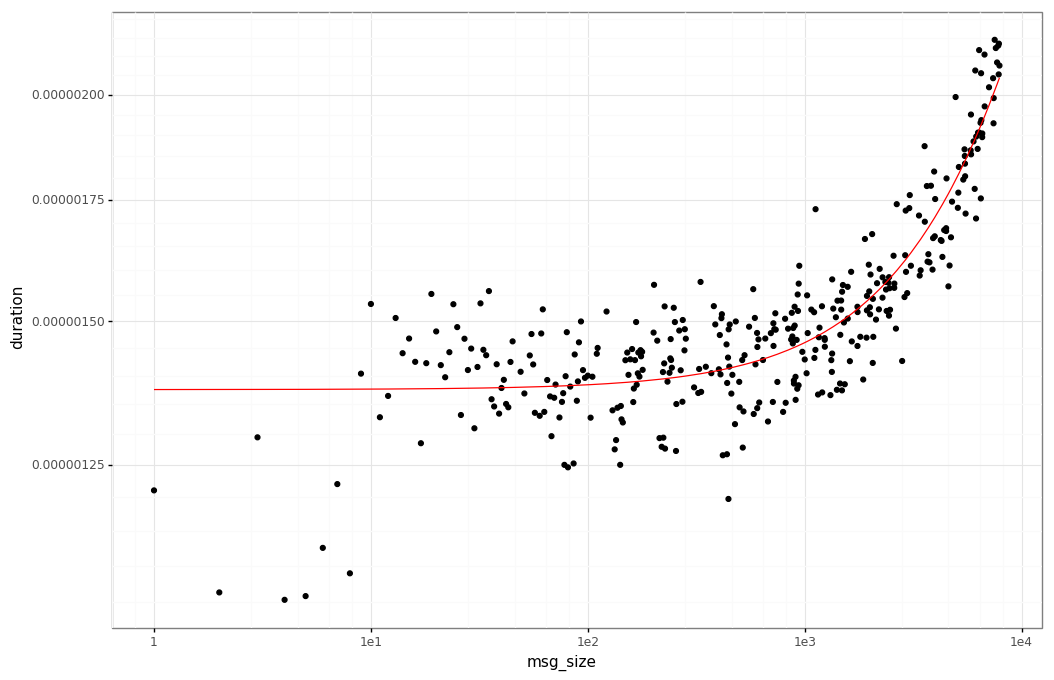

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1478.
Date:                Wed, 20 Feb 2019   Prob (F-statistic):          7.04e-130
Time:                        17:58:31   Log-Likelihood:                 5404.6
No. Observations:                 364   AIC:                        -1.081e+04
Df Residuals:                     362   BIC:                        -1.080e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.376e-06   5.76e-09    238.697      0.000    1.36e-06    1.39e-06
msg_size    8.444e-11    2.2e-12     38.450      0.000    8.01e-11    8.88e-11
==============================================================================
Omnibus:                       20.827   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.576
Skew:                          -0.423   Prob(JB):                     2.29e-07
Kurtosis:                       4.140   Cond. No.                     3.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ggplot: (-9223363309054025391)>


In [7]:
df = df_recv[df_recv.msg_size < 8133]

def aggregated_regression(df):
    df_aggr = df.groupby('msg_size')[['duration']].mean().reset_index()
    reg = st.ols(data=df_aggr, formula='duration ~ msg_size').fit()
    df_aggr['pred'] = df_aggr['msg_size'] * reg.params.msg_size + reg.params.Intercept
    print(ggplot(df_aggr) + geom_point(aes(x='msg_size', y='duration')) + scale_x_log10() + scale_y_log10() + theme_bw() + geom_line(aes(x='msg_size', y='pred'), color='red'))
    return reg

reg = aggregated_regression(df)
reg.summary()

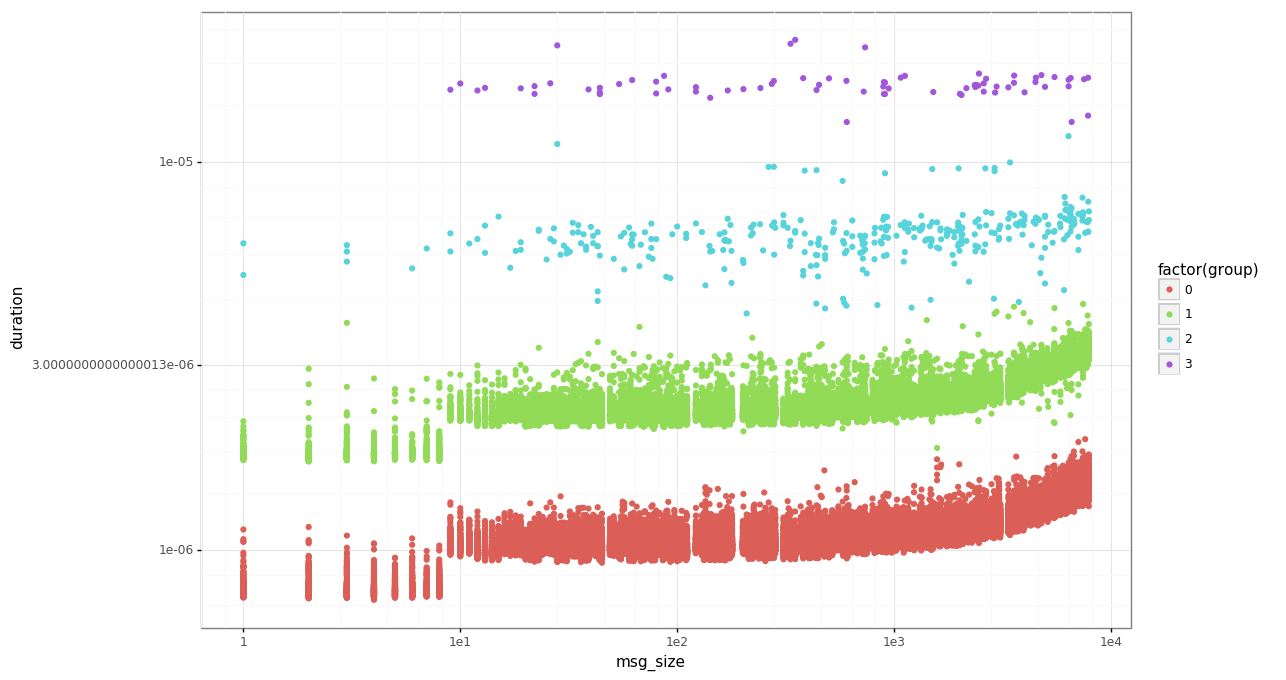

<ggplot: (8727800629701)>
   group          mean           std   count
0      0  9.681853e-07  8.229993e-08  129459
1      1  2.297517e-06  1.785319e-07   51780
2      2  6.310378e-06  9.581757e-07     630
3      3  1.578858e-05  1.353790e-06     131


<IPython.core.display.Math object>

In [8]:
df = df.copy()

def set_groups(df, reg_coeff, intercept_bounds):
    df['group'] = 0
    for i, bound in enumerate(intercept_bounds):
        df.loc[df['duration'] > df['msg_size'] * reg_coeff + bound, 'group'] = i+1
    print(ggplot(df.sample(n=100000)) + geom_point(aes(x='msg_size', y='duration', color='factor(group)')) + scale_x_log10() + scale_y_log10() + theme_bw())
    df['intercept_estimate'] = df['duration'] - df['msg_size'] * reg.params.msg_size
    summary = df.groupby('group')[['intercept_estimate']].agg(['mean', 'std', 'count'])
    summary.columns = summary.columns.droplevel()
    summary = summary.reset_index()
    print(summary)
    all_intercepts = []
    for _, row in summary.iterrows():
        all_intercepts.append((Normal(row['mean'], row['std']), row['count']))
    adhoc_reg = LinearRegression(
                    intercept = Mixture(*all_intercepts),
                    coefficient = reg.params.msg_size,
                )
    return adhoc_reg

adhoc_reg = set_groups(df, reg.params.msg_size, [1.6e-6, 4e-6, 1.2e-5])
adhoc_reg

In [9]:
df['pred'] = df.apply(lambda row: adhoc_reg.sample(row['msg_size']), axis=1)

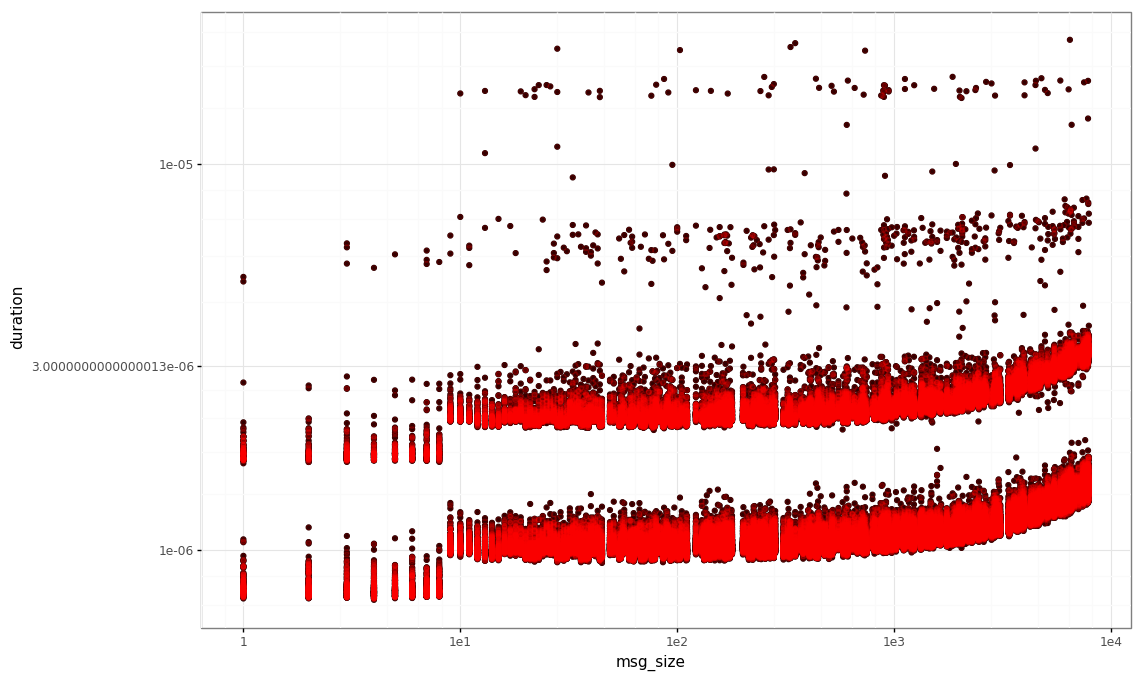

<ggplot: (-9223363309054144438)>

In [10]:
ggplot(df.sample(n=100000)) + geom_point(aes(x='msg_size', y='duration')) + geom_point(aes(x='msg_size', y='duration'), color='red', alpha=0.2) + scale_x_log10() + scale_y_log10() + theme_bw()

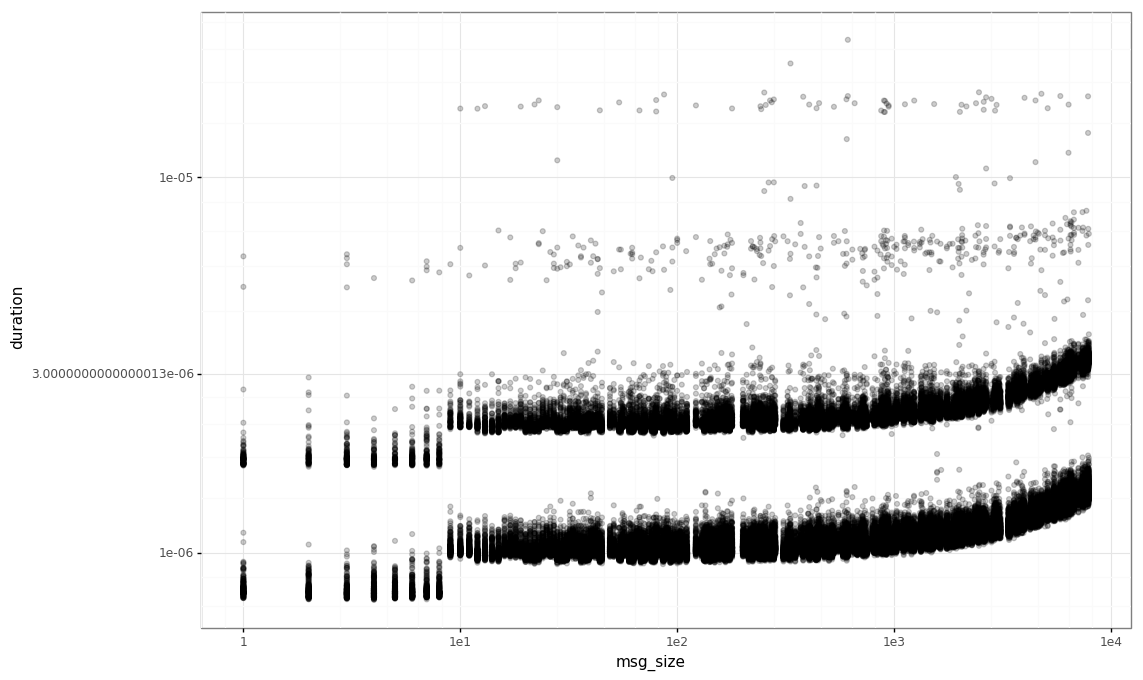

<ggplot: (-9223363309110884997)>


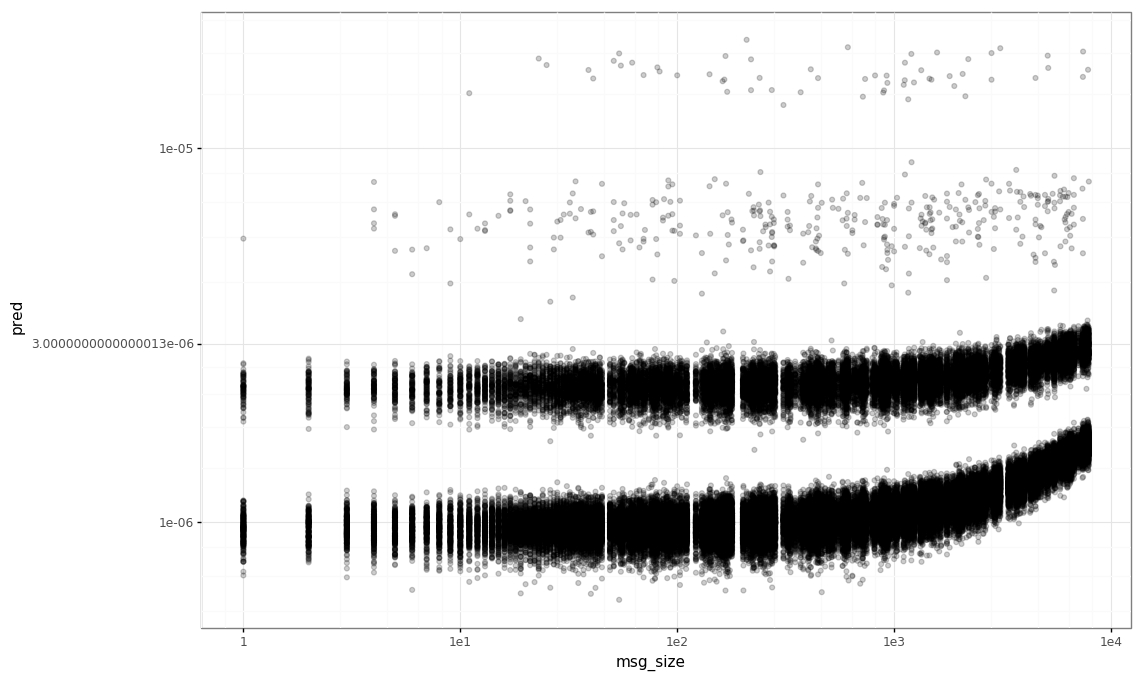

<ggplot: (8727744490844)>


In [11]:
tmp = df.sample(n=100000)
for y in ['duration', 'pred']:
    print(ggplot(tmp) + geom_point(aes(x='msg_size', y=y), alpha=0.2) + scale_x_log10() + scale_y_log10() + theme_bw())